In [753]:
import numpy as np
import pyccl as ccl
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.special import erf, gamma, expn, hyp2f1, exp1

# 3 components: dark matter, gas, stars   
Fourier (used in power spectrum): $y_{i}(k|m)\ \equiv \frac{\hat{\rho_i}(k|m)\ }{m} $   
where $\hat{\rho_i}(k|m)\ $ is the Fourier of the real density profile (frequently numerical)

- Need to get $\hat{\rho_i}(k|m)\ $, the Fourier of the real density profile
    - so get the real density profile of it, then calculate the numerical (built-in) Fourier profile

In [4]:
### Set up eg- cosmo
hmd_200c = ccl.halos.MassDef200c # use a mass definition with Delta = 200
cM = ccl.halos.ConcentrationDuffy08(mass_def=hmd_200c)
cosmo = ccl.Cosmology(Omega_c = 0.25, Omega_b=0.05, h=0.7, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)

trial_r = np.geomspace(1E-2,1E8,100000) # geomspace is like linspace, but evenly spaces on a logscale
trial_k = np.geomspace(1E-3,9E1,100000) # np.geomspace(1E-3,1E2,100000)
trial_M = np.array([3E12,6E13, 1E14])

In [355]:
### From CCLX

# We will use a mass definition with Delta = 200 times the matter density
hmd_200m = ccl.halos.MassDef(200, 'matter')
# The Tinker 2008 mass function
hmf_200m = ccl.halos.MassFuncTinker08(mass_def=hmd_200m, mass_def_strict=False)
# The Tinker 2010 halo bias
hbf = ccl.halos.HaloBiasTinker10(mass_def=hmd_200m, mass_def_strict=False)
# The Duffy 2008 concentration-mass relation
cM = ccl.halos.ConcentrationDuffy08(mass_def=hmd_200m)
# The NFW profile to characterize the matter density around halos
trial_nfwProf = ccl.halos.HaloProfileNFW(mass_def=hmd_200m, concentration=cM) # was pM = ...
hmc = ccl.halos.HMCalculator(mass_function=hmf_200m, halo_bias=hbf,mass_def=hmd_200m) # was hmc = ... 

## Stellar

- $\rho_*(x|m)=\frac{\rho_t}{x}\exp(-x^\alpha)$, with $x:=r/r_t$.
- Also: constraint on $\rho_t$ as require that the mass fraction overall is equal to the mass fraction within a halo.   
    - ie- $\frac{4 \pi}{\alpha} \rho_t r^3_t \left[ \Gamma(1 - \nu(\alpha )\ ) - x^2_{\Delta}\ E_{\nu({\alpha})} (x^{\alpha}_{\Delta}) \right] = m\ f_*(m)\ $
    - where $x_{\Delta} = R_{\Delta}/r_t $, $\Gamma $ is the gamma function, $E_{\nu}(t)$ is the exponential integral of order $\nu $, & $ \nu({\alpha}) \equiv 1 - \frac{2}{\alpha}$
    - $E_{\nu({\alpha})} (x^{\alpha}_{\Delta}) = $ scipy.special.expn( n = $\nu({\alpha}) $, x = $(x^{\alpha}_{\Delta}) $ )
        - so $v(\alpha )$ has to be an integer $n \ge 0$
        - So: $1 - \frac{2}{\alpha} \ge 0 \to \alpha \ge 2 $ AND $1 - \frac{2}{\alpha} $ must be an whole number
        - NOTE!! MAY BE PROBLEM IN ENFORCING THIS!
    - & $\Gamma(1 - \nu(\alpha )\ ) = $ scipy.special.gamma( z =  $(1 - \nu(\alpha ) $)
 
- ..
- $\rho_t = \frac{ m\ f_*(m)\ \alpha}{ 4 \pi r^3_t \left[ \Gamma(1 - \nu(\alpha )\ ) - x^2_{\Delta}\ E_{\nu({\alpha})} (x^{\alpha}_{\Delta}) \right]}$
- BUT
    - for moment, use $\rho_t = \frac{M f_*(M)\ }{4 \pi r_t^3}$ as in CCLX 

- The stellar mass fraction:
    - $f_*(m)=A\exp(-\frac{\log_{10}^2(m/m_{0s})}{2\sigma_s^2})$
    - NOTE: assuming that $log$ in Fedeli 2014 refers to $log10$, not $ln$
- Fix $A$ by requiring that $\bar{\rho}_*$ have a particular value:
    - $\bar{\rho}_*=\int_0^∞dmmf_*(m)n(m)$
    - where $n(m)$ is the halo mass function.
-  So $A = \frac{\bar{\rho}_*}{\int^{\infty}_0 dm\ m\ n(m)\ f_*(m)\ }$ (with $A$ not being included in $f_*(m)\ $ in the integral here obviously)

In [89]:
### some values that will be put in init (of StellarProfile) as self.X
### using values in CCLX code for trial 0
m_0s = 5E12/cosmo['h']
sigma_s = 1.2

# DM_mass_func = hmf_200m(cosmo,m,a_sf)/(m*np.log(10)) # under mf in def f_star_integrand(m)
hmd_200m = ccl.halos.MassDef(200, 'matter')
hmf_200m = ccl.halos.MassFuncTinker08(mass_def=hmd_200m, mass_def_strict=False)
# DM_mass_func = hmf_200m(cosmo, np.atleast_1d(trial_M), 1) / (np.atleast_1d(trial_M)*np.log(10))
# so want to move halo mass function into init, as need to generate DM_mass_func with the given halo's mass
rho_avg_star = 7E8*cosmo['h']**2 # under rho_star in CCLX

limInt_mStell = (1E10 , 1E15)  # mmin_stars=1E10, mmax_stars=1E15
# supposed to be (a,b) = (0,infty) BUT in reality can't practically use those limits

# alpha = 
# also want to have self.cosmo ?

In [729]:
class StellarProfile(ccl.halos.profiles.profile_base.HaloProfile):
    """ Stellar halo density profile. Fedeli (2014) arXiv:1401.2997
    """
    def __init__(self, cosmo, mass_def):
        ### will put in other parameters here later
        super(StellarProfile, self).__init__(mass_def=mass_def)
        self.cosmo = cosmo
     #   self.m_0s = 5E12 / self.cosmo['h']

    def _f_stell_noA(self, m):
        return np.exp( (-1/2) * ( np.log10(m/m_0s) /sigma_s )**2 )
    
    def _f_stell_integrand(self, m):
        # integrand = m * f_star(m) * n(m), where n(m,z) is the standard DM-only halo mass function
      #  DM_mass_func = hmf_200m(cosmo,m,a_sf)/(m*np.log(10)) # ? have as a self. ? (can't with scale_a, but-)
        DM_mass_func = hmf_200m(self.cosmo, np.atleast_1d(m), 1) / (np.atleast_1d(m)*np.log(10))
        return m* self._f_stell_noA(m) * DM_mass_func 
    
    # once we have A:   # f_star(m) = A*np.exp( (-1/2) * ( np.log10(m/m_0s) /omega_s )**2 )
    def _f_stell(self, m):
        # integrating over m (dm)
        integrad = integrate.quad(self._f_stell_integrand, limInt_mStell[0], limInt_mStell[1])
        A = rho_avg_star / integrad[0] #/ rho_avg_star
        return A * self._f_stell_noA(m)
    
    def _real(self, cosmo, r, M, scale_a=1, alpha = 1, r_t = 1, fedeli_rho_t=True):
        """ X
        """
        r_use = np.atleast_1d(r)
        M_use = np.atleast_1d(M)

        # r_t = 
        r_vir = self.mass_def.get_radius(self.cosmo, M_use, scale_a) / scale_a    # R_delta = the halo virial radius r_vir
        print(r_vir)
        f_stell = self._f_stell(M_use)

        x_delta = 1/0.03 # in CCLX example, as paper have for their eg: r_t / r_Delta = 0.03
        # x_delta = r_vir / r_t ## = R_Delta / r_t
### REMOVE AFTER!!
        r_t = x_delta/r_vir # as x_Delta = R_Delta/r_t, & enforcing for 1st trial that r_t/R_Delta = 0.03
        
   #     nu_alpha = 1 - (2 / alpha)
   #     rho_t = M_use * f_stell * alpha / (4 * np.pi * (r_t**3) * ( gamma(1 - nu_alpha) - (x_delta**2)*expn(nu_alpha, x_delta**alpha)) )
        if fedeli_rho_t is True:
            # Using Tassia's E_1 = int^infty_1 e^{-xt} * t dt = (e^{-x}*(x+1))/(x^2), assuming x = alpha here
            nu_alpha = 1 - (2 / alpha)
            rho_t = M_use*f_stell*alpha / (4*np.pi*(r_t**3) * (gamma(1 - nu_alpha) - (x_delta**2)*(x_delta**alpha)*(np.exp(-nu_alpha)*(nu_alpha+1))/(nu_alpha**2)) )
            print('Fedeli', rho_t)
            
        else: 
            rho_t = trial_M*f_stell / (4*np.pi*r_t**3) # using this 1 from CCLX for moment
            print('CCLX', rho_t)

        x = r_use[None, :] / r_t[:, None]
        prefix = rho_t * f_stell ## ASSUMING HERE that these are the prefix (relevant for [:, None] in next line)
        prof = prefix[:, None] * np.exp(-x**alpha)/x # (rho_t/x)*np.exp(-x** alpha) * f_stell
    # note: assuming that -x^alpha in eqn is meant to be -(x^alpha) (as code interprets it) as no brackets (for (-x)^alpha) in given eqn

        if np.ndim(r) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)
        return prof


# But for $\alpha=1$, if using $E_x = \int^{\infty}_1 e^{-xt}t dt = \frac{e^{-x}(x+1)}{x^2}$, with $x = \nu(\alpha)\ $
## Then get $E_{\nu(1)} = 0$, reducing $\rho_t$ to $\frac{ m\ f_*(m)\ \alpha}{ 4 \pi r^3_t \left[ \Gamma(1 - \nu(\alpha )\ )\right]}$
#### And $ \Gamma(1 - \nu(\alpha )\ = 1$ for $\alpha = 1$

In [759]:
expn(-1, 2)
## see that expn does not work for negative n
## (maybe when trialing, set alpha = 2? (or ask, whichever 1st) )
gamma(1 - (1 - 2/1))
exp1(1 - 2/1)
exp1(1)

0.21938393439552062

In [734]:
# want to have r_t as its own parameter, made using r_Delta = virial radius

In [736]:
trial_stelProf = StellarProfile(cosmo, hmd_200m) # trying the mass_def CCLX used

In [738]:
trial_stel_real = trial_stelProf._real(cosmo, trial_r, trial_M)
trial_stel_real

[0.44441462 1.20632687 1.43025866]
Fedeli [  12536.61281148 3915795.58621288 9273720.11598497]


array([[2.08330458e+06, 2.08282487e+06, 2.08234527e+06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.87152849e+08, 1.87109745e+08, 1.87066650e+08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.18704452e+08, 3.18631043e+08, 3.18557652e+08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [740]:
trial_stel_real_cclx = trial_stelProf._real(cosmo, trial_r, trial_M, fedeli_rho_t=False)
trial_stel_real_cclx

[0.44441462 1.20632687 1.43025866]
CCLX [  12536.61281148 3915795.58621288 9273720.11598497]


array([[2.08330458e+06, 2.08282487e+06, 2.08234527e+06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.87152849e+08, 1.87109745e+08, 1.87066650e+08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.18704452e+08, 3.18631043e+08, 3.18557652e+08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [744]:
np.all(trial_stel_real == trial_stel_real_cclx)

True

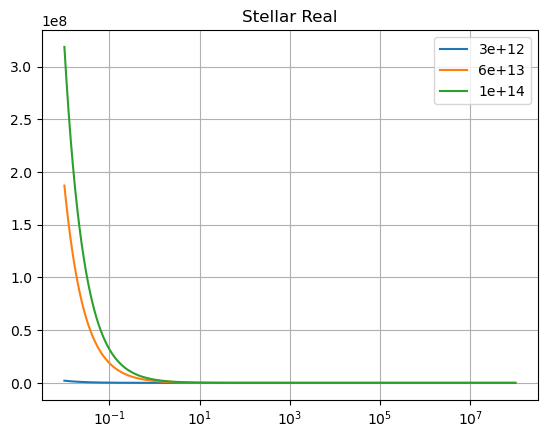

In [713]:
for mass, prof in zip(trial_M, trial_stel_real):
    plt.plot(trial_r, prof, label=f'{mass:.1g}');
plt.legend(loc='best')
plt.grid(True)
plt.xscale('log')
plt.title('Stellar Real');

In [715]:
trial_stelProf.update_precision_fftlog(padding_hi_fftlog=1E3,padding_lo_fftlog=1E-3,
                           n_per_decade=1000,plaw_fourier=-2.)
trial_stel_fourier = trial_stelProf.fourier(cosmo, trial_k, trial_M, 1)

[0.44441462 1.20632687 1.43025866]
[  12536.61281148 3915795.58621288 9273720.11598497]


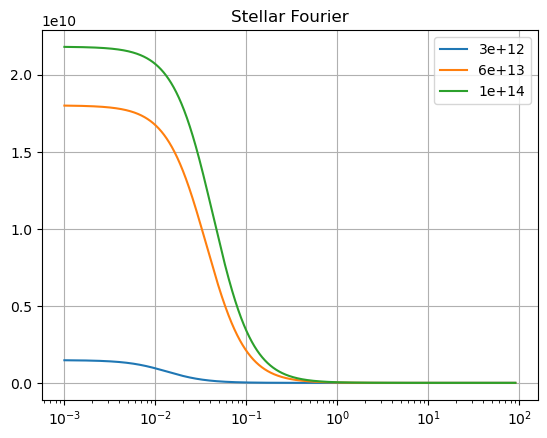

In [717]:
colours = ['tab:blue', 'orange', 'g']
for mass, prof, col in zip(trial_M, trial_stel_fourier, colours):
    plt.plot(trial_k, prof, label=f'{mass:.1g}')
   # plt.axhline(mass*trial_stelProf._f_stell(mass), color=col, linestyle='--');
plt.legend(loc='best')
plt.grid(True)
plt.xscale('log')
plt.title('Stellar Fourier');

In [723]:
trial_stelProf._f_stell(trial_M)

array([0.02215848, 0.01730294, 0.01475218])

## Gas

- The gas fraction in each halo approximately as:     
    - $f_g(m)=\frac{\Omega_b}{\Omega_m}\text{erf}\left[\frac{\log_{10}(m/m_{0g})}{\sigma_g}\right]$
    - for $m < m_{0g}$, we set $f_g\ = 0$

In [ ]:
def f_gas(m, ###
         m_0g= , sigma_g= 
         ):
    m_use = np.atleast_1d(m)
    f_array = np.zeros(np.shape(m_use))
    for i, mass in enumerate(m):
        if (mass < m_0g):
            f_array[i] = 0
        else:
            f_array[i] = (cosmo['Omega_b']/cosmo['Omega_m']) * erf(np.log10(mass/m_0g) / sigma_g)
    return f_array

In [303]:
### some values that will be put in init (of StellarProfile) as self.X
### using values in CCLX code for trial 0
m_0g = 5E12/cosmo['h']
sigma_g = 1.2

hmd_200m = ccl.halos.MassDef(200, 'matter')
#rho_avg_star = 7E8*cosmo['h']**2 # under rho_star in CCLX

# beta = 
# also want to have self.cosmo ?

- slightly different gas profile to Fedeli (2014) used in "Baryons_halo_model_power_spectrum" (CCLX):
    - $\rho_g(r)=\frac{\rho_{g,0}}{(1+u)^\beta(1+v^2)^{(7-\beta)/2}}$, with $u:=r/r_{co}$ and $v:=r/r_{ej}$.
- Fedeli 2014:
    - $\rho_g(r|m)=\frac{\rho_{c}}{(1+x^2)^{3\beta/2}}$, with $x:=r/r_{c}$
    - with the enforced relation of: $\frac{4}{3} \pi \rho_c r^3_c \left[ x_{\Delta}^3 ._2F_1 \left( \frac{3}{2}, \frac{3}{2}\beta, \frac{5}{2} ; -x^2_{\Delta} \right) \right] = m\ f_g(m)\ $
    - $x_{\Delta} = R_{\Delta}/r_c $
    - $._2F_1 \left( a, b, c; t \right) $ is the Gauss hypergeometric function $\to$ use scipy.special.hyp2f1(a, b, c, z, out=None)

In [337]:
class GasProfile(ccl.halos.profiles.profile_base.HaloProfile):
    """ Gas halo density profile. Fedeli (2014) arXiv:1401.2997
    """
    def __init__(self, mass_def):
        ### will put in other parameters here later
        super(GasProfile, self).__init__(mass_def=mass_def)

# want to have m_0g, sigma_g, & cosmo as self. in init
    def _f_gas(self, m):
        m_use = np.atleast_1d(m)
        f_array = np.zeros(np.shape(m_use))
        for i, mass in enumerate(m_use):
            if (mass < m_0g):
                f_array[i] = 0
            else:
                f_array[i] = (cosmo['Omega_b']/cosmo['Omega_m']) * erf(np.log10(mass/m_0g) / sigma_g)
        return f_array
    
    def _real(self, cosmo, r, M, scale_a=1, beta = 2/3, r_c = 1):
        """ X
        """
        r_use = np.atleast_1d(r)
        M_use = np.atleast_1d(M)

        # r_c = 
        r_vir = self.mass_def.get_radius(cosmo, M_use, scale_a) / scale_a    # R_delta = the halo virial radius r_vir
        f_gas = self._f_gas(M_use)

        x_delta = 1/0.05 # in CCLX example, as paper have for their eg: r_c / r_Delta = 0.05
        # x_delta = r_vir / r_c ## = R_Delta / r_c
### REMOVE AFTER!!
        r_c = x_delta/r_vir # as x_Delta = R_Delta/r_c, & enforcing for 1st trial that r_c/R_Delta = 0.05

        rho_bracket = (x_delta**3) * hyp2f1(3/2, 3*beta/2, 5/2, -(x_delta**2))
        rho_c = 3 * M_use * f_gas / (4 * np.pi * (r_c**3) * rho_bracket)
        
        x = r_use[None, :] / r_c[:, None]
        prefix = rho_c * f_gas ## ASSUMING HERE that these are the prefix (relevant for [:, None] in next line)
        prof = prefix[:, None] / ((1 + x**2 )**(3 * beta / 2) )

        if np.ndim(r) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)
        return prof


In [549]:
trial_gasProf = GasProfile(hmd_200m) # trying the mass_def CCLX used
trial_gas_real = trial_gasProf._real(cosmo, trial_r, trial_M)
trial_gas_real

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.25465074e+05, 8.25465074e+05, 8.25465073e+05, ...,
        2.27106128e-08, 2.27001565e-08, 2.26897050e-08],
       [2.96474225e+06, 2.96474225e+06, 2.96474225e+06, ...,
        5.80253797e-08, 5.79986639e-08, 5.79719604e-08]])

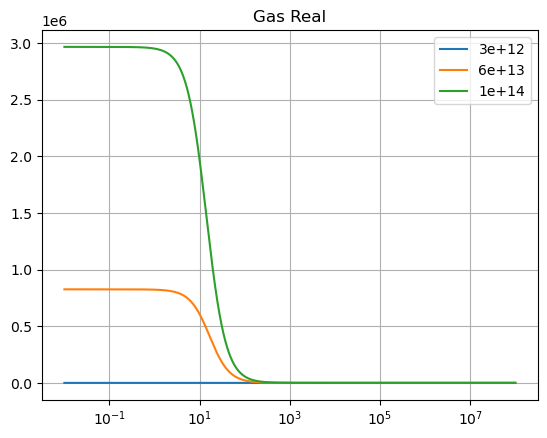

In [603]:
for mass, prof in zip(trial_M, trial_gas_real):
    plt.plot(trial_r, prof, label=f'{mass:.1g}');
plt.legend(loc='best')
plt.grid(True)
plt.xscale('log')
plt.title('Gas Real');

In [343]:
trial_gasProf._f_gas(trial_M[0])

array([0.])

In [553]:
trial_gasProf.update_precision_fftlog(padding_hi_fftlog=1E3,padding_lo_fftlog=1E-3,
                           n_per_decade=1000,plaw_fourier=-2.)
trial_gas_fourier = trial_gasProf.fourier(cosmo, trial_k, trial_M, 
                                          1)

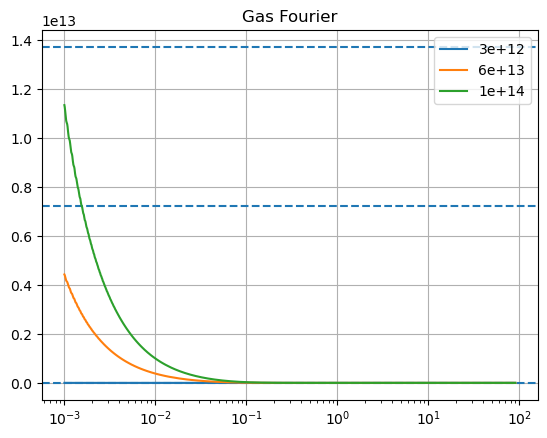

In [607]:
for mass, prof in zip(trial_M, trial_gas_fourier):
    plt.plot(trial_k, prof, label=f'{mass:.1g}');
    plt.axhline(mass*trial_gasProf._f_gas(mass), linestyle='--');
plt.legend(loc='best')
plt.grid(True)
plt.xscale('log')
plt.title('Gas Fourier');

In [609]:
trial_gasProf._f_gas(trial_M)

array([0.        , 0.12066112, 0.13720273])

In [615]:
for mass, prof in zip(trial_M, trial_gas_fourier):
    print(prof/trial_gasProf._f_gas(mass))

[nan nan nan ... nan nan nan]
[3.66937467e+13 3.66913386e+13 3.66889128e+13 ... 2.36533780e+04
 2.36533755e+04 2.36533733e+04]
[8.26628199e+13 8.26574088e+13 8.26519577e+13 ... 5.31504028e+04
 5.31503971e+04 5.31503922e+04]


/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_3992/3308567100.py:2: RuntimeWarning: invalid value encountered in divide
  print(prof/trial_gasProf._f_gas(mass))


## Dark Matter

- Real density profile = NFW: $\rho_{DM}(x|m)\ = \frac{\rho_s}{x(1+x)^2} $
- where:
    - $x = r/r_s $
    - $\rho_s = $ the scale density of the profile
    - $r_s = $ the scale radius of the profile
- Also concentration $c \equiv R_{\Delta}/r_s$
- Constraint on scale density $\rho_s $ requires that the total DM mass w/in the structure matches the DM mass fraction
    - $\rho_s = f_{DM}\ \frac{\Delta}{3} \bar{\rho_m} \frac{c^3}{G(c)\ } $ , where $G(c)\ $ is the "usual NFW concentration function"

In [371]:
# The NFW profile to characterize the matter density around halos
help(trial_nfwProf._fourier)

Help on method _fourier_analytic in module pyccl.halos.profiles.nfw:

_fourier_analytic(cosmo, k, M, a) method of pyccl.halos.profiles.nfw.HaloProfileNFW instance



------------------------------------------------
Just go with NFW profile for the dark matter profile, so that:
- $\rho_{DM}(r|m)\ = \rho_{NFW}(r|m)\ * f_{DM}$
- Dark matter mass fraction: $f_{DM}(m, z)\ = 1 - \frac{ \Omega_{b,0} }{ \Omega_{m,0} } $

In [579]:
trial_nfw_real = trial_nfwProf._real(cosmo, trial_r, trial_M, 
                                     1)
trial_nfw_fourier = trial_nfwProf._fourier(cosmo, trial_k, trial_M, 
                                           1)

trial_nfw_real

array([[5.46850792e+15, 5.46678261e+15, 5.46505776e+15, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.39451094e+16, 1.39415029e+16, 1.39378974e+16, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.59839286e+16, 1.59798770e+16, 1.59758264e+16, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [581]:
f_dm = 1 - cosmo['Omega_b'] / cosmo['Omega_m']
f_dm

0.8333333333333333

In [583]:
trial_dm_real = f_dm * trial_nfw_real
trial_dm_fourier = f_dm * trial_nfw_fourier

trial_dm_real

array([[4.55708993e+15, 4.55565218e+15, 4.55421480e+15, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.16209245e+16, 1.16179191e+16, 1.16149145e+16, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.33199405e+16, 1.33165642e+16, 1.33131887e+16, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

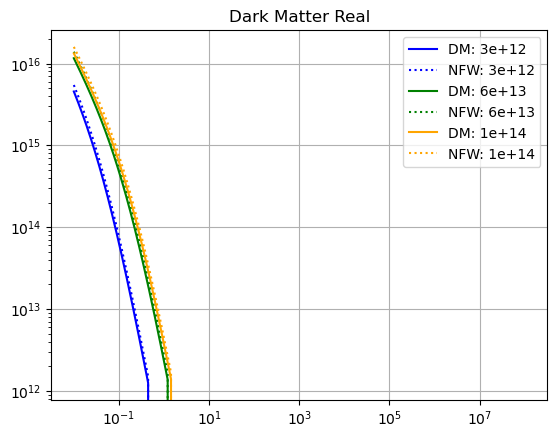

In [591]:
colours = ['b', 'g', 'orange']
for mass, prof, nfw, col in zip(trial_M, trial_dm_real, trial_nfw_real, colours):
    plt.plot(trial_r, prof, color=col, label=f'DM: {mass:.1g}');
    plt.plot(trial_r, nfw, ':', color=col, label=f'NFW: {mass:.1g}');
plt.legend(loc='best')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.title('Dark Matter Real');

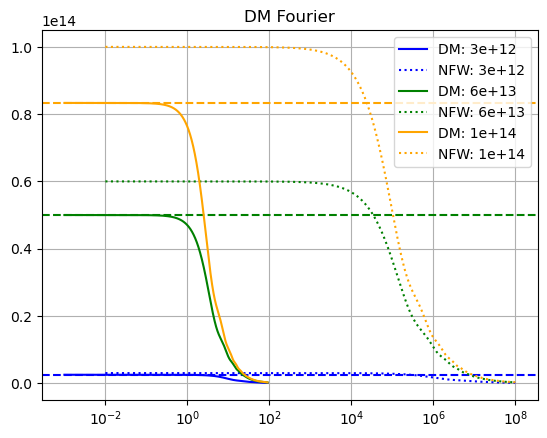

In [595]:
colours = ['b', 'g', 'orange']
for mass, prof, nfw, col in zip(trial_M, trial_dm_fourier, trial_nfw_fourier, colours):
    plt.plot(trial_k, prof, color=col, label=f'DM: {mass:.1g}');
    plt.axhline(mass*f_dm, color=col, linestyle='--');
    plt.plot(trial_r, nfw, ':', color=col, label=f'NFW: {mass:.1g}');
plt.legend(loc='best')
plt.grid(True)
plt.xscale('log')
plt.title('DM Fourier');

# Combine the profiles into 1 (sum)

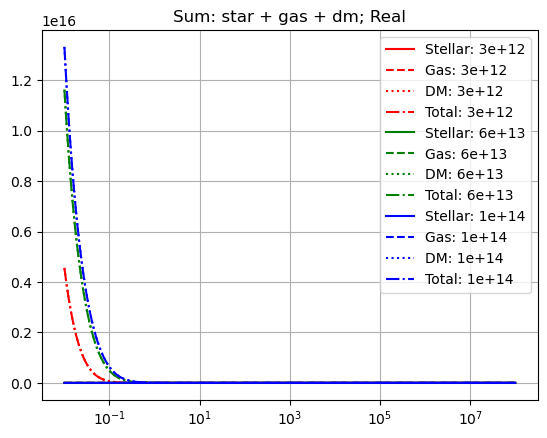

In [597]:
colours = ['r', 'g', 'b', 'k']
for mass, stel, gas, dm, col in zip(trial_M, trial_stel_real, trial_gas_real, trial_dm_real, colours):
    plt.plot(trial_r, stel, '-', color=col, label=f'Stellar: {mass:.1g}');
    plt.plot(trial_r, gas, '--', color=col, label=f'Gas: {mass:.1g}');
    plt.plot(trial_r, dm, ':', color=col, label=f'DM: {mass:.1g}');
    plt.plot(trial_r, dm+stel+gas, '-.', color=col, label=f'Total: {mass:.1g}');
plt.legend(loc='best')
plt.grid(True)
plt.xscale('log')
plt.title('Sum: star + gas + dm; Real');

In [561]:
trial_sum_real = trial_stel_real + trial_gas_real + trial_dm_real
trial_sum_fourier = trial_stel_fourier + trial_gas_fourier + trial_dm_fourier

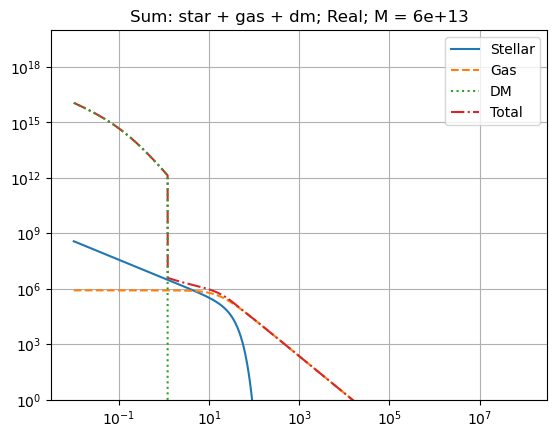

In [599]:
colours = ['r', 'g', 'b', 'k']
i = 1
plt.plot(trial_r, trial_stel_real[i], '-', label='Stellar');
plt.plot(trial_r, trial_gas_real[i], '--', label='Gas');
plt.plot(trial_r, trial_dm_real[i], ':', label='DM', zorder=5);
plt.plot(trial_r, trial_sum_real[i], '-.', label='Total');
plt.legend(loc='best')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1E0, 1E20)
plt.title(f'Sum: star + gas + dm; Real; M = {trial_M[i]:.1g}');

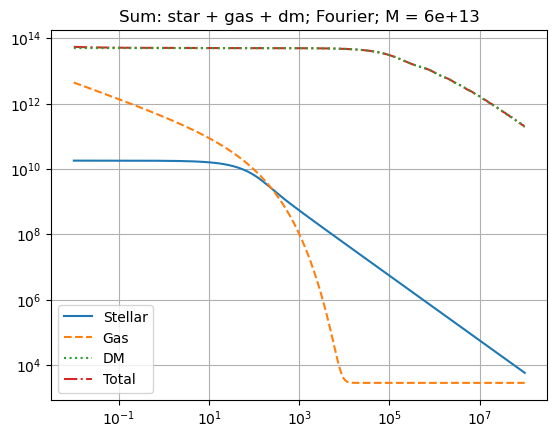

In [601]:
colours = ['r', 'g', 'b', 'k']
i = 1
plt.plot(trial_r, trial_stel_fourier[i], '-', label='Stellar');
plt.plot(trial_r, trial_gas_fourier[i], '--', label='Gas');
plt.plot(trial_r, trial_dm_fourier[i], ':', label='DM', zorder=5);
plt.plot(trial_r, trial_sum_fourier[i], '-.', label='Total');
plt.legend(loc='best')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.title(f'Sum: star + gas + dm; Fourier; M = {trial_M[i]:.1g}');

In [491]:
trial_stel_fourier

array([8.15787257e+16, 8.15787244e+16, 8.15787230e+16, ...,
       4.68283062e+10, 4.68176236e+10, 4.68069434e+10])

In [493]:
trial_dm_fourier

array([1.19047605e+14, 1.19047605e+14, 1.19047605e+14, ...,
       2.41241597e+11, 2.41211368e+11, 2.41182017e+11])